In [34]:
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, ConfusionMatrixDisplay, auc, roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
import pickle

In [2]:
df = pd.read_csv("../data/processed/gladiador_data_procesado.csv")
df.head()

,Wins,Public Favor,Survived,Allegiance Network_Strong
0,11,0.841842,False,1
1,7,0.651044,True,0
2,6,0.593816,True,1
3,6,0.540815,False,1
4,12,0.761651,False,1


In [3]:
df['Survived'] = df['Survived'].astype(int)
df.head()

,Wins,Public Favor,Survived,Allegiance Network_Strong
0,11,0.841842,0,1
1,7,0.651044,1,0
2,6,0.593816,1,1
3,6,0.540815,0,1
4,12,0.761651,0,1


## MODELO GRADIENT BOOSTING CLASSIFIER

In [4]:
X = df[["Wins", "Public Favor", "Allegiance Network_Strong"]]
y = df["Survived"]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(7980, 3)
(7980,)
(1996, 3)
(1996,)


In [6]:
gbc = GradientBoostingClassifier(max_depth=5,n_estimators=100, random_state=42, learning_rate=0.5)
cv_gbc = cross_val_score(estimator=gbc, X=X, y=y,cv=10,scoring="accuracy")

In [7]:
print(cv_gbc)
print(cv_gbc.mean())

[0.67635271 0.70240481 0.70240481 0.69338677 0.70240481 0.69038076
 0.69709127 0.70110331 0.69007021 0.70310933]
0.6958708791705778


In [8]:
#Creo un DataFrame completo de entrenamiento combinando X_train y y_train
train_df = pd.concat([X_train, y_train], axis=1)

#Creo un DataFrame completo de prueba combinando X_test y y_test
test_df = pd.concat([X_test, y_test], axis=1)

# Guardar los DataFrames en archivos CSV
train_df.to_csv("../data/train/train_data.csv", index=False)
test_df.to_csv("../data/test/test_data.csv", index=False)

In [9]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [11]:
with open("../models/gbc_model.pkl", "wb") as f:
    pickle.dump(gbc, f)

In [12]:
gbc.fit(X_train, y_train)

GradientBoostingClassifier(learning_rate=0.5, max_depth=5, random_state=42)

In [17]:
#Realizo Predicciones

# Predicciones sobre el mismo conjunto de datos de entrenamiento
pred_gbc = gbc.predict(X_test)

In [18]:
#Obtengo las PROBABILIDADES de predicción
pred_proba = gbc.predict_proba(X_test)[:, 1]

In [19]:
results_test_df = X_test.copy()
results_test_df['Actual Survived'] = y_test
results_test_df['Predicted Survived'] = pred_gbc
print("\nDataFrame con Predicciones para el conjunto de PRUEBA:")
print(results_test_df.head())


DataFrame con Predicciones para el conjunto de PRUEBA:
      Wins  Public Favor  Allegiance Network_Strong  Actual Survived  \
5825     9      0.729941                          1                0   
5171    14      0.911117                          1                1   
6041     6      0.602053                          0                0   
107     10      0.709351                          1                0   
3422    12      0.861939                          1                1   

      Predicted Survived  
5825                   1  
5171                   1  
6041                   0  
107                    0  
3422                   1  


In [20]:
full_predictions = gbc.predict(X)
df['Predicted Survived'] = full_predictions
print("\nDataFrame original con Predicciones para TODO el conjunto de datos:")
print(df.head())


DataFrame original con Predicciones para TODO el conjunto de datos:
   Wins  Public Favor  Survived  Allegiance Network_Strong  Predicted Survived
0    11      0.841842         0                          1                   1
1     7      0.651044         1                          0                   1
2     6      0.593816         1                          1                   1
3     6      0.540815         0                          1                   0
4    12      0.761651         0                          1                   0


In [22]:
# Predecir para un nuevo dato, por ejemplo:
# Un personaje con 8 victorias, 0.7 de favor público y una red de lealtad fuerte (1)
new_data = pd.DataFrame([[8, 0.7, 1]], columns=["Wins", "Public Favor", "Allegiance Network_Strong"])
new_prediction = gbc.predict(new_data)

print(f"\nPredicción para un nuevo personaje (Wins: 8, Public Favor: 0.7, Allegiance Network_Strong: 1): {new_prediction[0]}")

if new_prediction[0] == 1:
    print("El modelo predice que este personaje Sobreviviría.")
else:
    print("El modelo predice que este personaje No Sobreviviría.")


Predicción para un nuevo personaje (Wins: 8, Public Favor: 0.7, Allegiance Network_Strong: 1): 1
El modelo predice que este personaje Sobreviviría.


In [25]:
print("--- Métricas de Clasificación ---")
print("Precisión (Accuracy): ", accuracy_score(y_test, pred_gbc))
print("Precisión (Clase 1): ", precision_score(y_test, pred_gbc))
print("Sensibilidad (Recall - Clase 1): ", recall_score(y_test, pred_gbc))
print("Puntuación F1 (Clase 1): ", f1_score(y_test, pred_gbc))
# Si pred_dtc son probabilidades, podrías calcular el ROC AUC:
print("ROC AUC: ", roc_auc_score(y_test, pred_proba))

--- Métricas de Clasificación ---
Precisión (Accuracy):  0.685370741482966
Precisión (Clase 1):  0.6676136363636364
Sensibilidad (Recall - Clase 1):  0.7179226069246436
Puntuación F1 (Clase 1):  0.6918547595682041
ROC AUC:  0.7535566227599755


In [27]:
# Obtengo las importancias de las características
importances = gbc.feature_importances_

# Crear una Serie de Pandas para facilitar la visualización
feature_names = X.columns.tolist() # Me aseguro de tener los nombres de mis columnas
feature_importance_df = pd.Series(importances, index=feature_names).sort_values(ascending=False)

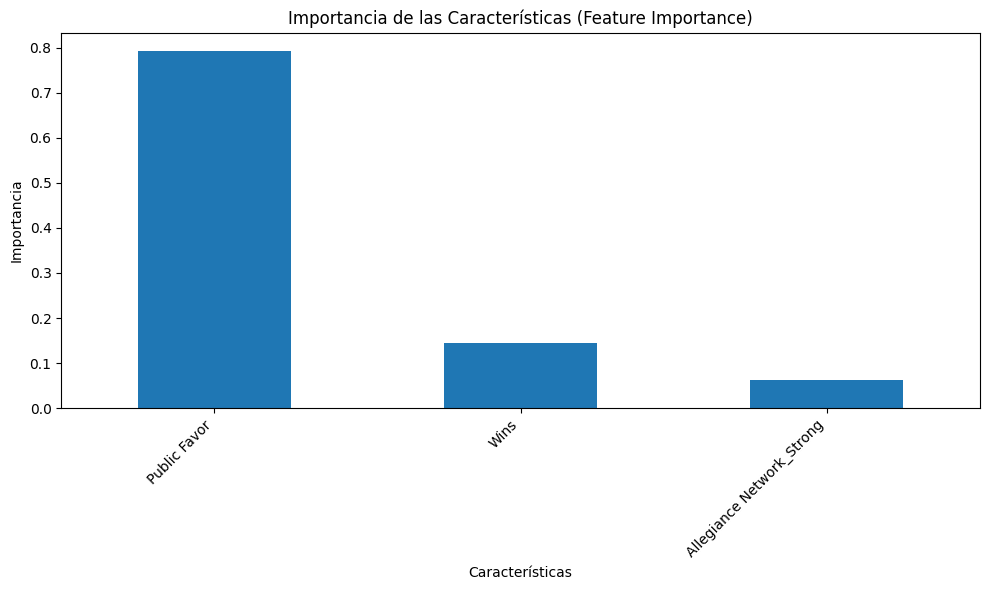

In [28]:
# Visualizar
plt.figure(figsize=(10, 6))
feature_importance_df.plot(kind='bar')
plt.title('Importancia de las Características (Feature Importance)')
plt.xlabel('Características')
plt.ylabel('Importancia')
plt.xticks(rotation=45, ha='right') # Rotar etiquetas para mejor legibilidad
plt.tight_layout() # Ajustar el diseño para que todo quepa
plt.show()

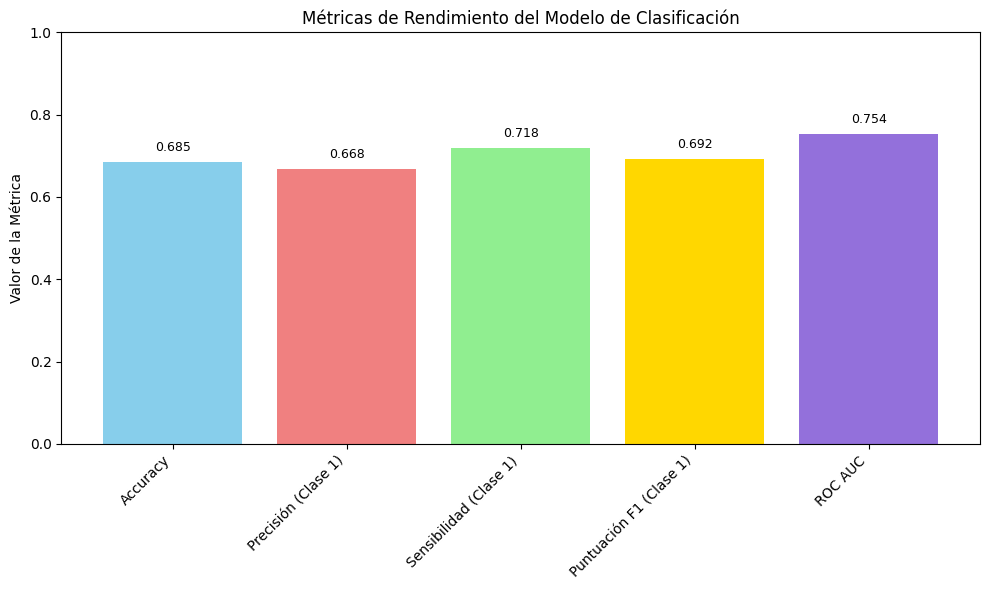

In [29]:
metrics_names = [
    'Accuracy',
    'Precisión (Clase 1)',
    'Sensibilidad (Clase 1)',
    'Puntuación F1 (Clase 1)',
    'ROC AUC'
]
metrics_values = [
    0.685370741482966,
    0.6676136363636364,
    0.7179226069246436,
    0.6918547595682041,
    0.7535566227599755
]

plt.figure(figsize=(10, 6))
bars = plt.bar(metrics_names, metrics_values, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'mediumpurple'])
plt.ylabel('Valor de la Métrica')
plt.title('Métricas de Rendimiento del Modelo de Clasificación')
plt.ylim(0, 1) # Las métricas suelen oscilar entre 0 y 1

# Añade el valor exacto encima de cada barra para mayor claridad
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, yval + 0.02, round(yval, 3), ha='center', va='bottom', fontsize=9)

plt.xticks(rotation=45, ha='right') # Rota las etiquetas para una mejor legibilidad
plt.tight_layout() # Ajusta el diseño para evitar que las etiquetas se superpongan
plt.show()

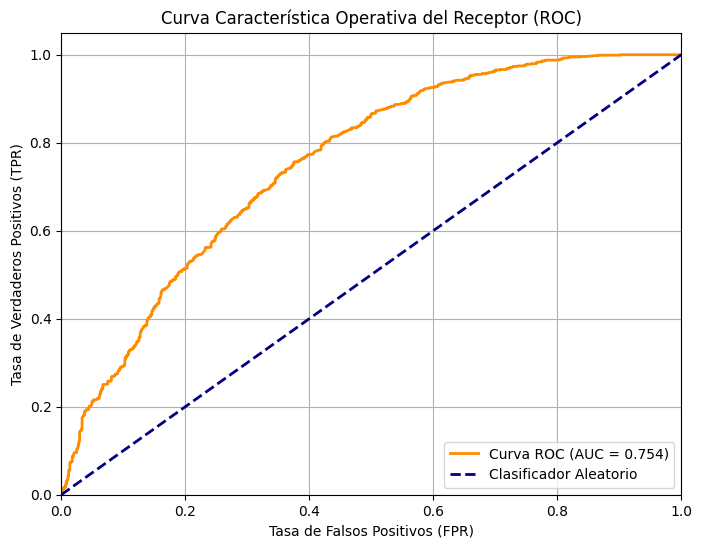

In [33]:
fpr, tpr, thresholds = roc_curve(y_test, pred_proba)
roc_auc = auc(fpr, tpr) # Esto debería coincidir con tu ROC AUC proporcionado: 0.7535566

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'Curva ROC (AUC = {roc_auc:.3f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Clasificador Aleatorio')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('Tasa de Falsos Positivos (FPR)')
plt.ylabel('Tasa de Verdaderos Positivos (TPR)')
plt.title('Curva Característica Operativa del Receptor (ROC)')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

<Figure size 800x600 with 0 Axes>

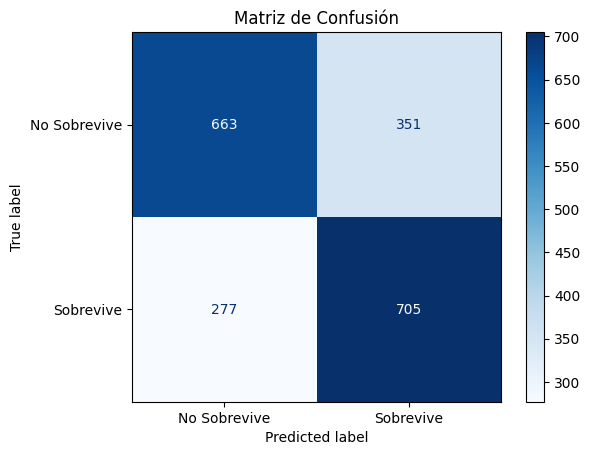

In [35]:
cm = confusion_matrix(y_test, pred_gbc)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['No Sobrevive', 'Sobrevive'])

plt.figure(figsize=(8, 6))
disp.plot(cmap=plt.cm.Blues, values_format='d') # 'd' para formato entero
plt.title('Matriz de Confusión')
plt.show()